In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joypy
import datetime
import gc
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import random

root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"

def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

In [2]:
root_audios_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_audios.csv"
root_recorders_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_recorders.csv"
root_ai_Zamuro = f"{root}/Zamuro/AI_Caract/AI_Zamuro.csv"
root_vggish_Zamuro = f"{root}/Zamuro/vggish/Features_vggish"

audios = pd.read_csv(root_audios_Zamuro, index_col=0)
recorders = pd.read_csv(root_recorders_Zamuro, index_col=0)
ai = pd.read_csv(root_ai_Zamuro, index_col=0)
ai.dropna(inplace=True)
ai.set_index("file",inplace=True, drop=True)
ai.drop(columns=["Date"], inplace=True)
def combinar_nombre_ubicacion(row):
    return f"{row['field_number_PR']}_{row['Filename']}"

# Aplicando la función a cada fila del DataFrame para crear la nueva columna
audios['Filename_'] = audios.apply(combinar_nombre_ubicacion, axis=1)

audios.set_index("Filename_", inplace=True)

# AE

### Covers

In [3]:
accuracies_ae_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ae_unflat_covers.npy")
f1_scores_ae_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ae_unflat_covers.npy")
recalls_ae_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ae_unflat_covers.npy")

### Hours

In [4]:
accuracies_ae_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ae_unflat_hours.npy")
f1_scores_ae_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ae_unflat_hours.npy")
recalls_ae_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ae_unflat_hours.npy")

# VGGISH

### Covers

In [5]:
accuracies_vgg_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_vgg_covers.npy")
f1_scores_vgg_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_vgg_covers.npy")
recalls_vgg_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_vgg_covers.npy")

### Hours

In [6]:
accuracies_vgg_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_vgg_hours.npy")
f1_scores_vgg_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_vgg_hours.npy")
recalls_vgg_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_vgg_hours.npy")

# Acoustic Indices (AIs)

### Covers

In [7]:
accuracies_ai_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ai_covers.npy")
f1_scores_ai_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ai_covers.npy")
recalls_ai_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ai_covers.npy")

### Hours

In [8]:
accuracies_ai_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ai_hours.npy")
f1_scores_ai_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ai_hours.npy")
recalls_ai_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ai_hours.npy")

# Graphics Covers

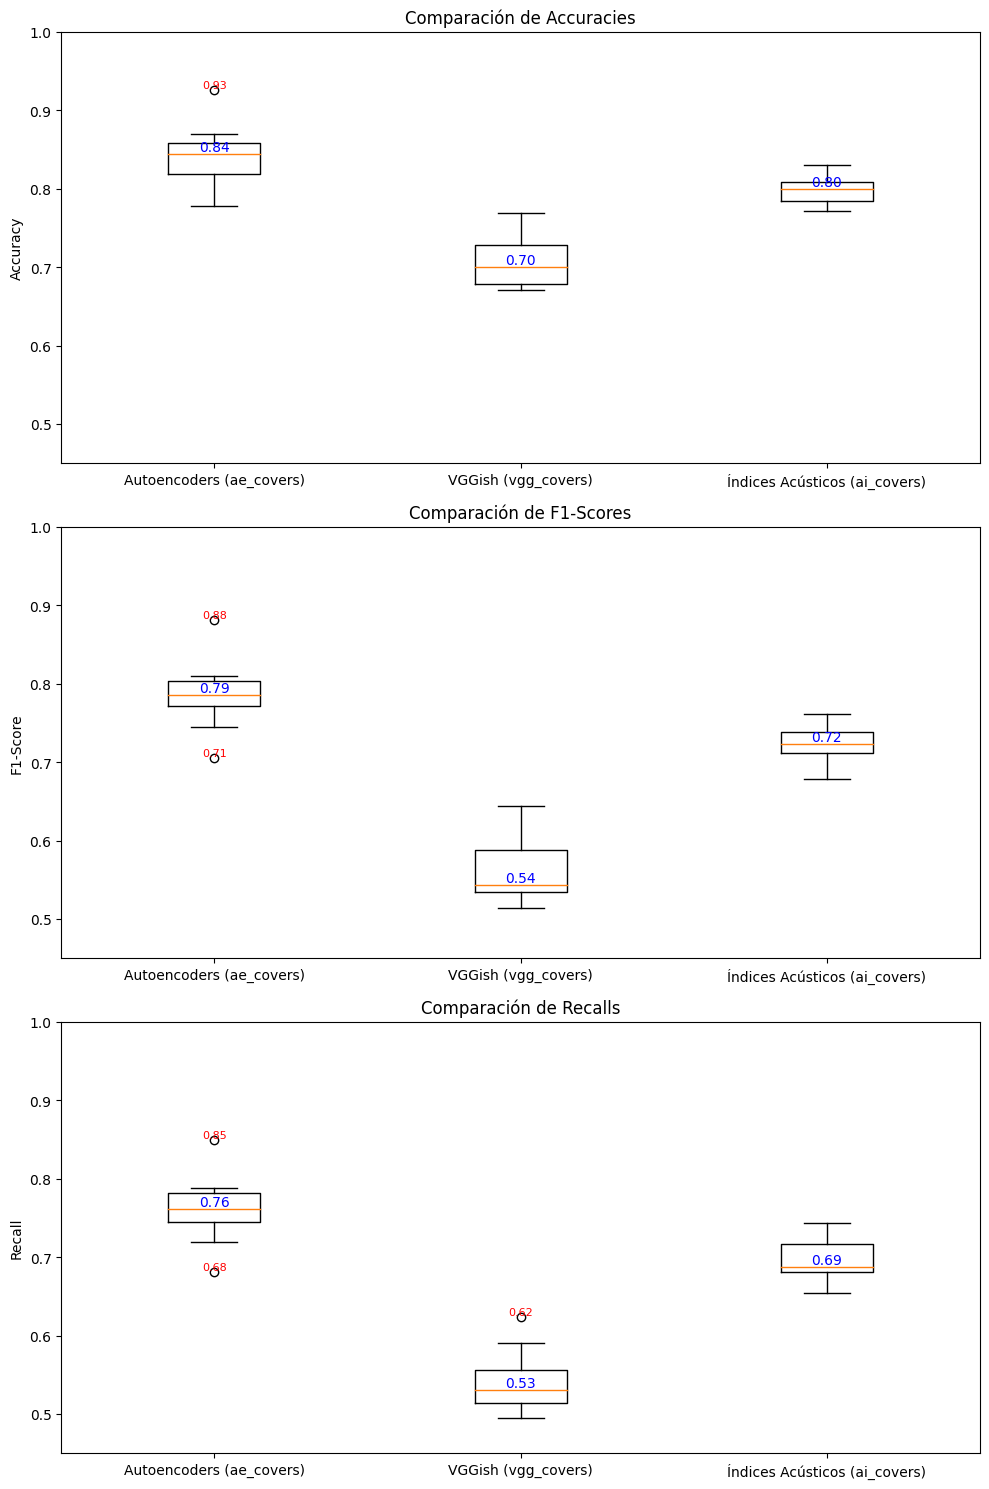

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Establecer límites del eje y
y_min = 0.45
y_max = 1

# Función para agregar anotaciones de mediana y outliers
def add_annotations(ax, data):
    for i, d in enumerate(data):
        # Añadir la mediana
        median = np.median(d)
        ax.text(i + 1, median, f'{median:.2f}', ha='center', va='bottom', color='blue', fontsize=10)
        
        # Añadir los outliers
        outliers = [point for point in d if point > np.percentile(d, 75) + 1.5 * (np.percentile(d, 75) - np.percentile(d, 25)) or point < np.percentile(d, 25) - 1.5 * (np.percentile(d, 75) - np.percentile(d, 25))]
        for outlier in outliers:
            ax.text(i + 1, outlier, f'{outlier:.2f}', ha='center', va='bottom', color='red', fontsize=8)

# Gráfica de accuracies
bp_acc = axs[0].boxplot([accuracies_ae_covers, accuracies_vgg_covers, accuracies_ai_covers], labels=['Autoencoders (ae_covers)', 'VGGish (vgg_covers)', 'Índices Acústicos (ai_covers)'])
axs[0].set_title('Comparación de Accuracies')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(y_min, y_max)  # Límite del eje y
add_annotations(axs[0], [accuracies_ae_covers, accuracies_vgg_covers, accuracies_ai_covers])

# Gráfica de F1-scores
bp_f1 = axs[1].boxplot([f1_scores_ae_covers, f1_scores_vgg_covers, f1_scores_ai_covers], labels=['Autoencoders (ae_covers)', 'VGGish (vgg_covers)', 'Índices Acústicos (ai_covers)'])
axs[1].set_title('Comparación de F1-Scores')
axs[1].set_ylabel('F1-Score')
axs[1].set_ylim(y_min, y_max)  # Límite del eje y
add_annotations(axs[1], [f1_scores_ae_covers, f1_scores_vgg_covers, f1_scores_ai_covers])
            

# Gráfica de Recalls
bp_rec = axs[2].boxplot([recalls_ae_covers, recalls_vgg_covers, recalls_ai_covers], labels=['Autoencoders (ae_covers)', 'VGGish (vgg_covers)', 'Índices Acústicos (ai_covers)'])
axs[2].set_title('Comparación de Recalls')
axs[2].set_ylabel('Recall')
axs[2].set_ylim(y_min, y_max)  # Límite del eje y
add_annotations(axs[2], [recalls_ae_covers, recalls_vgg_covers, recalls_ai_covers])



plt.savefig(f"temporal_zamuro/zamuro_classification_results/figures/results_classification_covers")
# Mostrar las gráficas
plt.tight_layout()
plt.show()

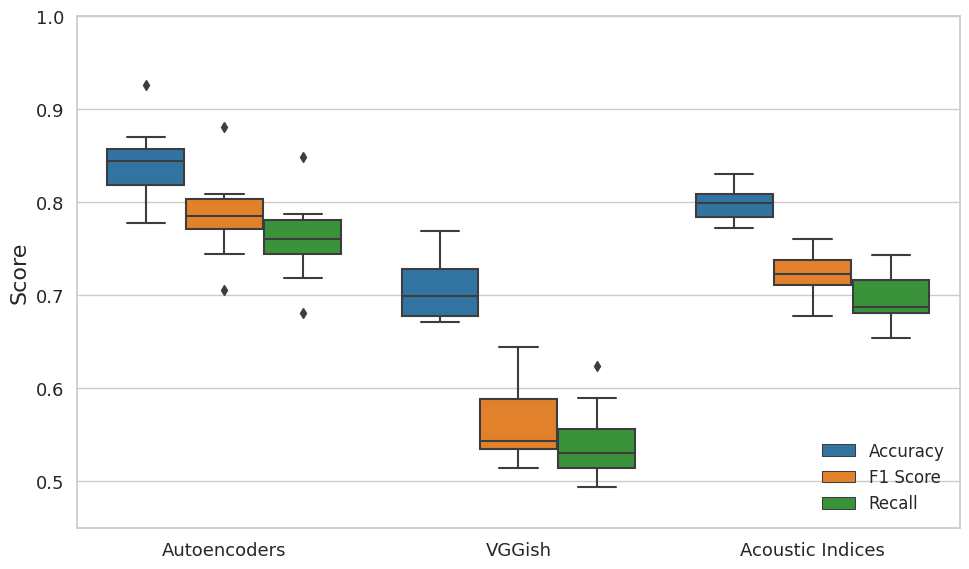

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Crear DataFrame
def build_dataframe(metric_values, metric_name, technique_name):
    return pd.DataFrame({
        'Score': metric_values,
        'Metric': metric_name,
        'Technique': technique_name
    })

# Construcción del DataFrame
df = pd.concat([
    build_dataframe(accuracies_ae_covers, 'Accuracy', 'Autoencoders'),
    build_dataframe(f1_scores_ae_covers, 'F1 Score', 'Autoencoders'),
    build_dataframe(recalls_ae_covers, 'Recall', 'Autoencoders'),
    build_dataframe(accuracies_vgg_covers, 'Accuracy', 'VGGish'),
    build_dataframe(f1_scores_vgg_covers, 'F1 Score', 'VGGish'),
    build_dataframe(recalls_vgg_covers, 'Recall', 'VGGish'),
    build_dataframe(accuracies_ai_covers, 'Accuracy', 'Acoustic Indices'),
    build_dataframe(f1_scores_ai_covers, 'F1 Score', 'Acoustic Indices'),
    build_dataframe(recalls_ai_covers, 'Recall', 'Acoustic Indices')
], ignore_index=True)

# Estética Seaborn
sns.set(style="whitegrid", font_scale=1.4)
palette = {'Accuracy': '#1f77b4', 'F1 Score': '#ff7f0e', 'Recall': '#2ca02c'}

# Crear el gráfico
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='Technique', y='Score', hue='Metric', palette=palette)

# Límites del eje y
ax.set_ylim(0.45, 1)

# Estética de ejes
ax.set_xlabel('')
ax.set_ylabel('Score', fontsize=16)
ax.tick_params(labelsize=13)
ax.legend(title='', fontsize=12, loc='lower right')

# Guardar y mostrar
plt.tight_layout()
plt.savefig("temporal_zamuro/zamuro_classification_results/figures/seaborn_combined_boxplot_covers.pdf",format="pdf", dpi=300)
plt.show()



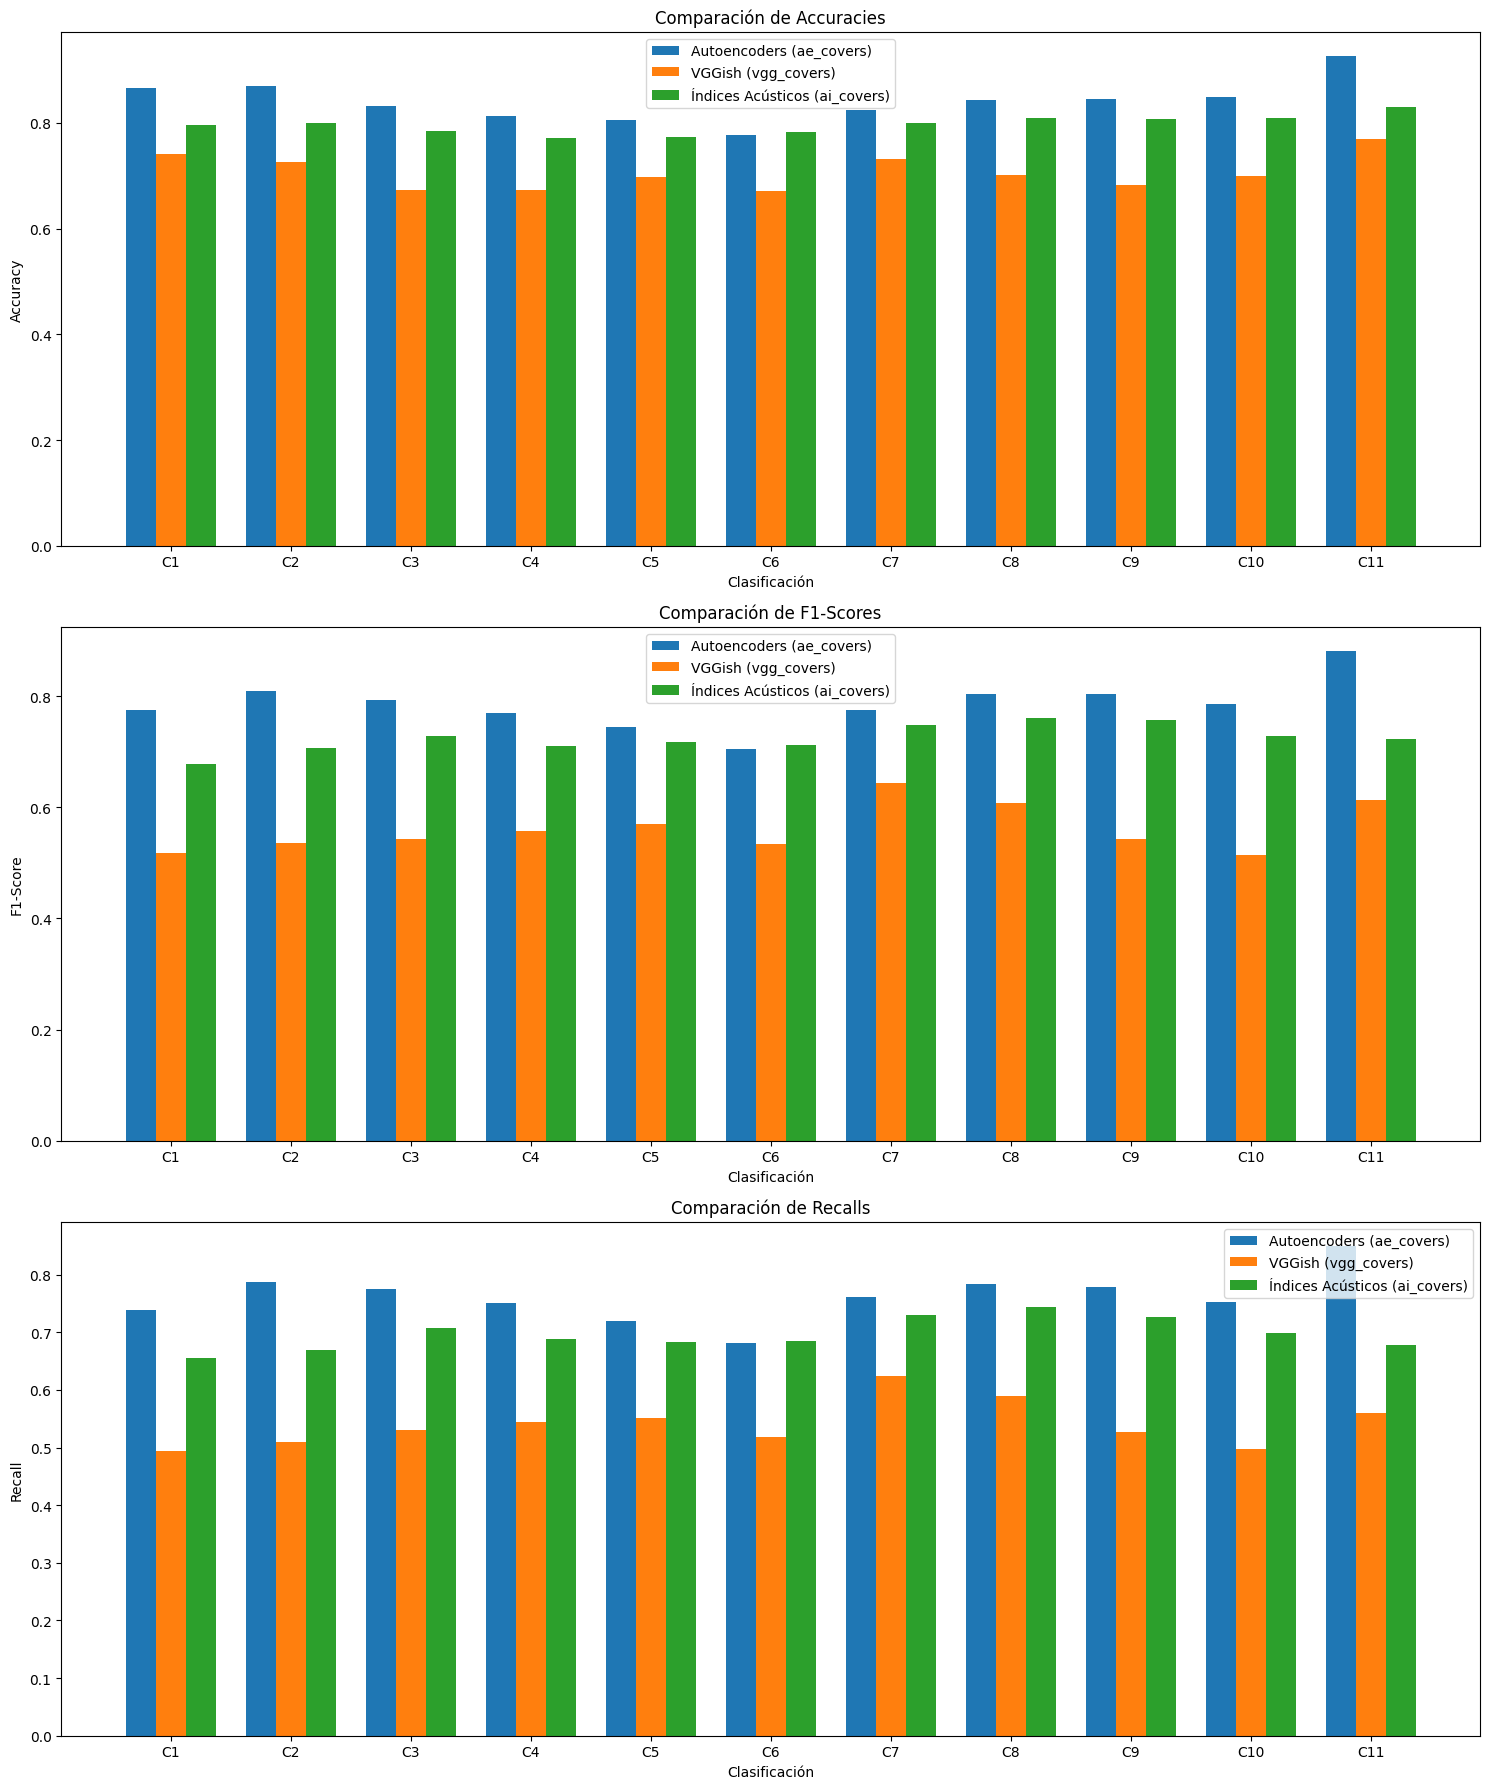

In [10]:
n = len(accuracies_ae_covers)

# Posiciones para las barras
ind = np.arange(n)  # la posición de las barras en el eje X
width = 0.25  # el ancho de las barras

fig, axs = plt.subplots(3, 1, figsize=(15, 18))

# Gráfica de accuracies
axs[0].bar(ind - width, accuracies_ae_covers, width, label='Autoencoders (ae_covers)')
axs[0].bar(ind, accuracies_vgg_covers, width, label='VGGish (vgg_covers)')
axs[0].bar(ind + width, accuracies_ai_covers, width, label='Índices Acústicos (ai_covers)')
axs[0].set_title('Comparación de Accuracies')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Clasificación')
axs[0].set_xticks(ind)
axs[0].set_xticklabels([f'C{i+1}' for i in ind])  # Etiquetas para cada clasificación
axs[0].legend(loc='best')

# Gráfica de F1-scores
axs[1].bar(ind - width, f1_scores_ae_covers, width, label='Autoencoders (ae_covers)')
axs[1].bar(ind, f1_scores_vgg_covers, width, label='VGGish (vgg_covers)')
axs[1].bar(ind + width, f1_scores_ai_covers, width, label='Índices Acústicos (ai_covers)')
axs[1].set_title('Comparación de F1-Scores')
axs[1].set_ylabel('F1-Score')
axs[1].set_xlabel('Clasificación')
axs[1].set_xticks(ind)
axs[1].set_xticklabels([f'C{i+1}' for i in ind])  # Etiquetas para cada clasificación
axs[1].legend(loc='best')

# Gráfica de Recalls
axs[2].bar(ind - width, recalls_ae_covers, width, label='Autoencoders (ae_covers)')
axs[2].bar(ind, recalls_vgg_covers, width, label='VGGish (vgg_covers)')
axs[2].bar(ind + width, recalls_ai_covers, width, label='Índices Acústicos (ai_covers)')
axs[2].set_title('Comparación de Recalls')
axs[2].set_ylabel('Recall')
axs[2].set_xlabel('Clasificación')
axs[2].set_xticks(ind)
axs[2].set_xticklabels([f'C{i+1}' for i in ind])  # Etiquetas para cada clasificación
axs[2].legend(loc='best')

# Ajustar la disposición de las gráficas
plt.tight_layout()
plt.show()

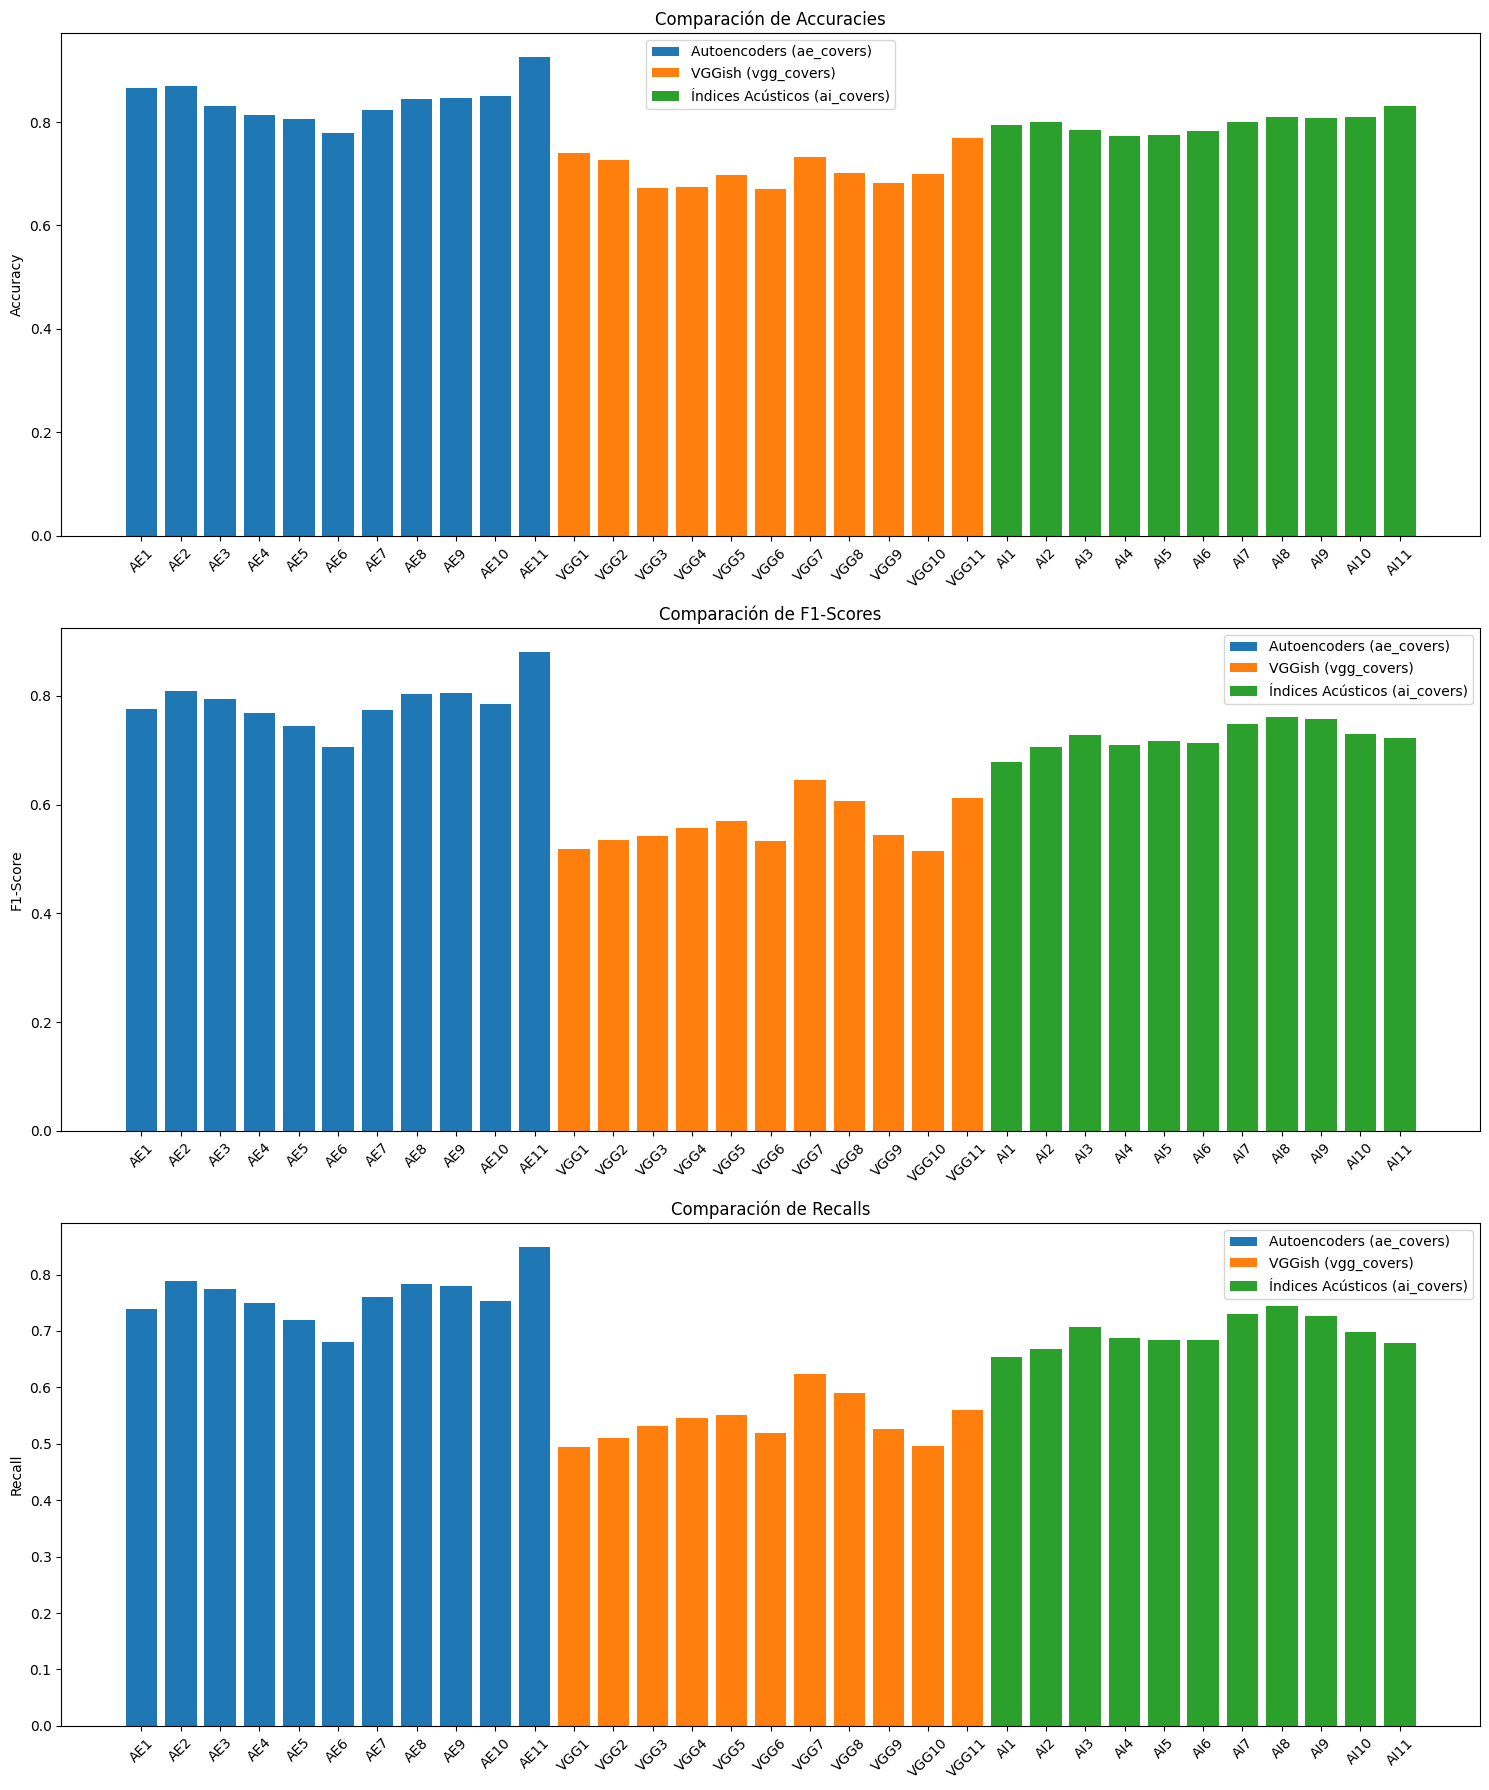

In [11]:
n = len(accuracies_ae_covers)

# Posiciones para las barras en el eje X
ind_ae = np.arange(n)  # Posiciones de las barras para el método AE
ind_vgg = np.arange(n, 2*n)  # Posiciones de las barras para el método VGGish
ind_ai = np.arange(2*n, 3*n)  # Posiciones de las barras para el método AI

# Ancho de las barras
width = 0.8  # el ancho de las barras, más amplio para que las barras estén más juntas dentro de cada grupo

fig, axs = plt.subplots(3, 1, figsize=(15, 18))

# Gráfica de accuracies
axs[0].bar(ind_ae, accuracies_ae_covers, width, label='Autoencoders (ae_covers)')
axs[0].bar(ind_vgg, accuracies_vgg_covers, width, label='VGGish (vgg_covers)')
axs[0].bar(ind_ai, accuracies_ai_covers, width, label='Índices Acústicos (ai_covers)')
axs[0].set_title('Comparación de Accuracies')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(np.concatenate([ind_ae, ind_vgg, ind_ai]))
axs[0].set_xticklabels(['AE'+str(i+1) for i in range(n)] + ['VGG'+str(i+1) for i in range(n)] + ['AI'+str(i+1) for i in range(n)], rotation=45)
axs[0].legend(loc='best')

# Gráfica de F1-scores
axs[1].bar(ind_ae, f1_scores_ae_covers, width, label='Autoencoders (ae_covers)')
axs[1].bar(ind_vgg, f1_scores_vgg_covers, width, label='VGGish (vgg_covers)')
axs[1].bar(ind_ai, f1_scores_ai_covers, width, label='Índices Acústicos (ai_covers)')
axs[1].set_title('Comparación de F1-Scores')
axs[1].set_ylabel('F1-Score')
axs[1].set_xticks(np.concatenate([ind_ae, ind_vgg, ind_ai]))
axs[1].set_xticklabels(['AE'+str(i+1) for i in range(n)] + ['VGG'+str(i+1) for i in range(n)] + ['AI'+str(i+1) for i in range(n)], rotation=45)
axs[1].legend(loc='best')

# Gráfica de Recalls
axs[2].bar(ind_ae, recalls_ae_covers, width, label='Autoencoders (ae_covers)')
axs[2].bar(ind_vgg, recalls_vgg_covers, width, label='VGGish (vgg_covers)')
axs[2].bar(ind_ai, recalls_ai_covers, width, label='Índices Acústicos (ai_covers)')
axs[2].set_title('Comparación de Recalls')
axs[2].set_ylabel('Recall')
axs[2].set_xticks(np.concatenate([ind_ae, ind_vgg, ind_ai]))
axs[2].set_xticklabels(['AE'+str(i+1) for i in range(n)] + ['VGG'+str(i+1) for i in range(n)] + ['AI'+str(i+1) for i in range(n)], rotation=45)
axs[2].legend(loc='best')

# Ajustar la disposición de las gráficas
plt.tight_layout()
plt.show()

In [12]:
from scipy.stats import friedmanchisquare, wilcoxon
friedman_acc = friedmanchisquare(accuracies_ae_covers, accuracies_vgg_covers, accuracies_ai_covers)
friedman_f1 = friedmanchisquare(f1_scores_ae_covers, f1_scores_vgg_covers, f1_scores_ai_covers)
friedman_rec = friedmanchisquare(recalls_ae_covers, recalls_vgg_covers, recalls_ai_covers)

print(f"Friedman Test for Accuracies: Statistic={friedman_acc.statistic}, p-value={friedman_acc.pvalue}")
print(f"Friedman Test for F1-Scores: Statistic={friedman_f1.statistic}, p-value={friedman_f1.pvalue}")
print(f"Friedman Test for Recalls: Statistic={friedman_rec.statistic}, p-value={friedman_rec.pvalue}")

Friedman Test for Accuracies: Statistic=20.181818181818187, p-value=4.145470838528921e-05
Friedman Test for F1-Scores: Statistic=20.181818181818187, p-value=4.145470838528921e-05
Friedman Test for Recalls: Statistic=20.181818181818187, p-value=4.145470838528921e-05


In [23]:
accuracies_ae_covers, accuracies_ai_covers, accuracies_vgg_covers

(array([0.86626506, 0.87001224, 0.83153786, 0.81400137, 0.80511403,
        0.77793318, 0.82363281, 0.84427907, 0.84608541, 0.84958678,
        0.92608696]),
 array([0.79518072, 0.8004896 , 0.78454333, 0.77213452, 0.7740152 ,
        0.78321678, 0.79980469, 0.81023256, 0.80782918, 0.80991736,
        0.83043478]),
 array([0.74096386, 0.72582619, 0.67291179, 0.67398765, 0.69730477,
        0.67132867, 0.73144531, 0.70232558, 0.68238434, 0.69972452,
        0.76956522]))

In [26]:
from scipy.stats import friedmanchisquare, wilcoxon
import itertools

# Diccionarios con las métricas por técnica
accuracy_data = {
    'AE': accuracies_ae_covers,
    'VGG': accuracies_vgg_covers,
    'AI': accuracies_ai_covers
}
f1_data = {
    'AE': f1_scores_ae_covers,
    'VGG': f1_scores_vgg_covers,
    'AI': f1_scores_ai_covers
}
recall_data = {
    'AE': recalls_ae_covers,
    'VGG': recalls_vgg_covers,
    'AI': recalls_ai_covers
}

# === Friedman Tests ===
friedman_acc = friedmanchisquare(*accuracy_data.values())
friedman_f1 = friedmanchisquare(*f1_data.values())
friedman_rec = friedmanchisquare(*recall_data.values())

print("\n--- Friedman Test Results ---")
print(f"Accuracy   → Statistic = {friedman_acc.statistic:.3f}, p-value = {friedman_acc.pvalue:.5f}")
print(f"F1 Score   → Statistic = {friedman_f1.statistic:.3f}, p-value = {friedman_f1.pvalue:.5f}")
print(f"Recall     → Statistic = {friedman_rec.statistic:.3f}, p-value = {friedman_rec.pvalue:.5f}")


--- Friedman Test Results ---
Accuracy   → Statistic = 20.182, p-value = 0.00004
F1 Score   → Statistic = 20.182, p-value = 0.00004
Recall     → Statistic = 20.182, p-value = 0.00004


In [13]:
wilcoxon_acc_ae_vgg = wilcoxon(accuracies_ae_covers, accuracies_vgg_covers)
wilcoxon_acc_ae_ai = wilcoxon(accuracies_ae_covers, accuracies_ai_covers)

wilcoxon_f1_ae_vgg = wilcoxon(f1_scores_ae_covers, f1_scores_vgg_covers)
wilcoxon_f1_ae_ai = wilcoxon(f1_scores_ae_covers, f1_scores_ai_covers)

wilcoxon_rec_ae_vgg = wilcoxon(recalls_ae_covers, recalls_vgg_covers)
wilcoxon_rec_ae_ai = wilcoxon(recalls_ae_covers, recalls_ai_covers)

print(f"Wilcoxon Test Accuracies AE vs VGG: Statistic={wilcoxon_acc_ae_vgg.statistic}, p-value={wilcoxon_acc_ae_vgg.pvalue}")
print(f"Wilcoxon Test Accuracies AE vs AI: Statistic={wilcoxon_acc_ae_ai.statistic}, p-value={wilcoxon_acc_ae_ai.pvalue}")

print(f"Wilcoxon Test F1-Scores AE vs VGG: Statistic={wilcoxon_f1_ae_vgg.statistic}, p-value={wilcoxon_f1_ae_vgg.pvalue}")
print(f"Wilcoxon Test F1-Scores AE vs AI: Statistic={wilcoxon_f1_ae_ai.statistic}, p-value={wilcoxon_f1_ae_ai.pvalue}")

print(f"Wilcoxon Test Recalls AE vs VGG: Statistic={wilcoxon_rec_ae_vgg.statistic}, p-value={wilcoxon_rec_ae_vgg.pvalue}")
print(f"Wilcoxon Test Recalls AE vs AI: Statistic={wilcoxon_rec_ae_ai.statistic}, p-value={wilcoxon_rec_ae_ai.pvalue}")

Wilcoxon Test Accuracies AE vs VGG: Statistic=0.0, p-value=0.0009765625
Wilcoxon Test Accuracies AE vs AI: Statistic=1.0, p-value=0.001953125
Wilcoxon Test F1-Scores AE vs VGG: Statistic=0.0, p-value=0.0009765625
Wilcoxon Test F1-Scores AE vs AI: Statistic=1.0, p-value=0.001953125
Wilcoxon Test Recalls AE vs VGG: Statistic=0.0, p-value=0.0009765625
Wilcoxon Test Recalls AE vs AI: Statistic=1.0, p-value=0.001953125


In [27]:
from scipy.stats import wilcoxon
import itertools

# === Wilcoxon Pairwise Function ===
def run_pairwise_wilcoxon(data_dict, metric_name):
    print(f"\n--- Wilcoxon Pairwise Tests for {metric_name} ---")
    for (name1, values1), (name2, values2) in itertools.combinations(data_dict.items(), 2):
        try:
            result = wilcoxon(values1, values2)
            print(f"{name1} vs {name2} → Statistic = {result.statistic:.3f}, p-value = {result.pvalue:.4f}")
        except ValueError as e:
            print(f"{name1} vs {name2} → Wilcoxon test failed ({e})")

# Ejecutar para cada métrica
run_pairwise_wilcoxon(accuracy_data, "Accuracy")
run_pairwise_wilcoxon(f1_data, "F1 Score")
run_pairwise_wilcoxon(recall_data, "Recall")


--- Wilcoxon Pairwise Tests for Accuracy ---
AE vs VGG → Statistic = 0.000, p-value = 0.0010
AE vs AI → Statistic = 1.000, p-value = 0.0020
VGG vs AI → Statistic = 0.000, p-value = 0.0010

--- Wilcoxon Pairwise Tests for F1 Score ---
AE vs VGG → Statistic = 0.000, p-value = 0.0010
AE vs AI → Statistic = 1.000, p-value = 0.0020
VGG vs AI → Statistic = 0.000, p-value = 0.0010

--- Wilcoxon Pairwise Tests for Recall ---
AE vs VGG → Statistic = 0.000, p-value = 0.0010
AE vs AI → Statistic = 1.000, p-value = 0.0020
VGG vs AI → Statistic = 0.000, p-value = 0.0010


## Graphics Hours

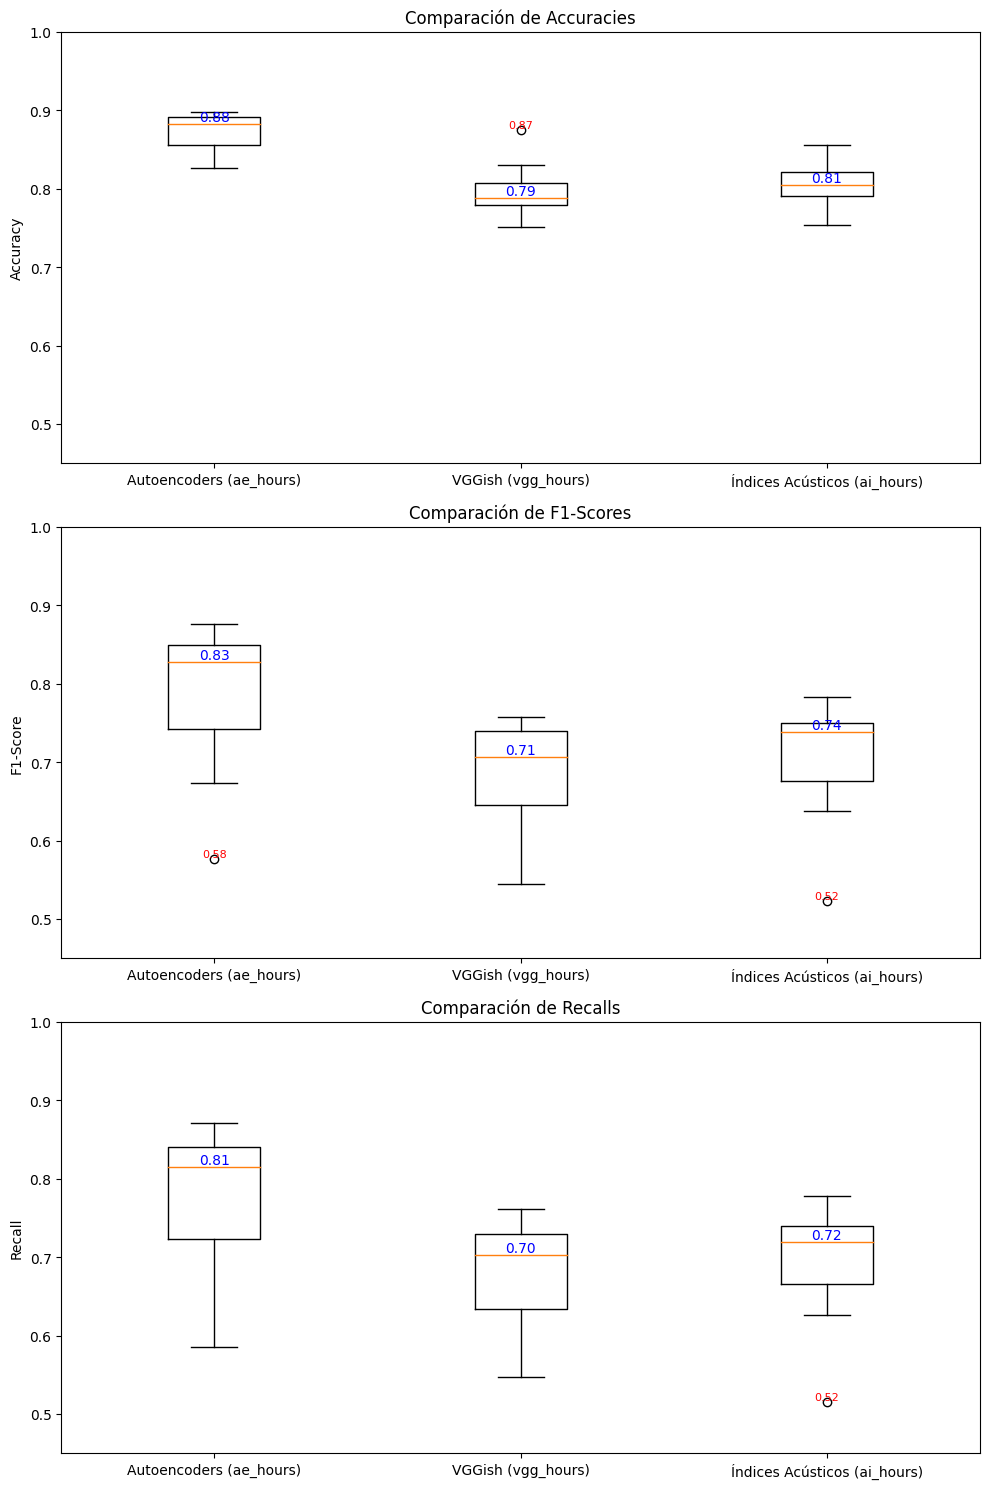

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Establecer límites del eje y
y_min = 0.45
y_max = 1

# Función para agregar anotaciones de mediana y outliers
def add_annotations(ax, data):
    for i, d in enumerate(data):
        # Añadir la mediana
        median = np.median(d)
        ax.text(i + 1, median, f'{median:.2f}', ha='center', va='bottom', color='blue', fontsize=10)
        
        # Añadir los outliers
        outliers = [point for point in d if point > np.percentile(d, 75) + 1.5 * (np.percentile(d, 75) - np.percentile(d, 25)) or point < np.percentile(d, 25) - 1.5 * (np.percentile(d, 75) - np.percentile(d, 25))]
        for outlier in outliers:
            ax.text(i + 1, outlier, f'{outlier:.2f}', ha='center', va='bottom', color='red', fontsize=8)

# Gráfica de accuracies
bp_acc = axs[0].boxplot([accuracies_ae_hours, accuracies_vgg_hours, accuracies_ai_hours], labels=['Autoencoders (ae_hours)', 'VGGish (vgg_hours)', 'Índices Acústicos (ai_hours)'])
axs[0].set_title('Comparación de Accuracies')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(y_min, y_max)  # Límite del eje y
add_annotations(axs[0], [accuracies_ae_hours, accuracies_vgg_hours, accuracies_ai_hours])

# Gráfica de F1-scores
bp_f1 = axs[1].boxplot([f1_scores_ae_hours, f1_scores_vgg_hours, f1_scores_ai_hours], labels=['Autoencoders (ae_hours)', 'VGGish (vgg_hours)', 'Índices Acústicos (ai_hours)'])
axs[1].set_title('Comparación de F1-Scores')
axs[1].set_ylabel('F1-Score')
axs[1].set_ylim(y_min, y_max)  # Límite del eje y
add_annotations(axs[1], [f1_scores_ae_hours, f1_scores_vgg_hours, f1_scores_ai_hours])

# Gráfica de Recalls
bp_rec = axs[2].boxplot([recalls_ae_hours, recalls_vgg_hours, recalls_ai_hours], labels=['Autoencoders (ae_hours)', 'VGGish (vgg_hours)', 'Índices Acústicos (ai_hours)'])
axs[2].set_title('Comparación de Recalls')
axs[2].set_ylabel('Recall')
axs[2].set_ylim(y_min, y_max)  # Límite del eje y
add_annotations(axs[2], [recalls_ae_hours, recalls_vgg_hours, recalls_ai_hours])

# Mostrar las gráficas
plt.tight_layout()
plt.show()

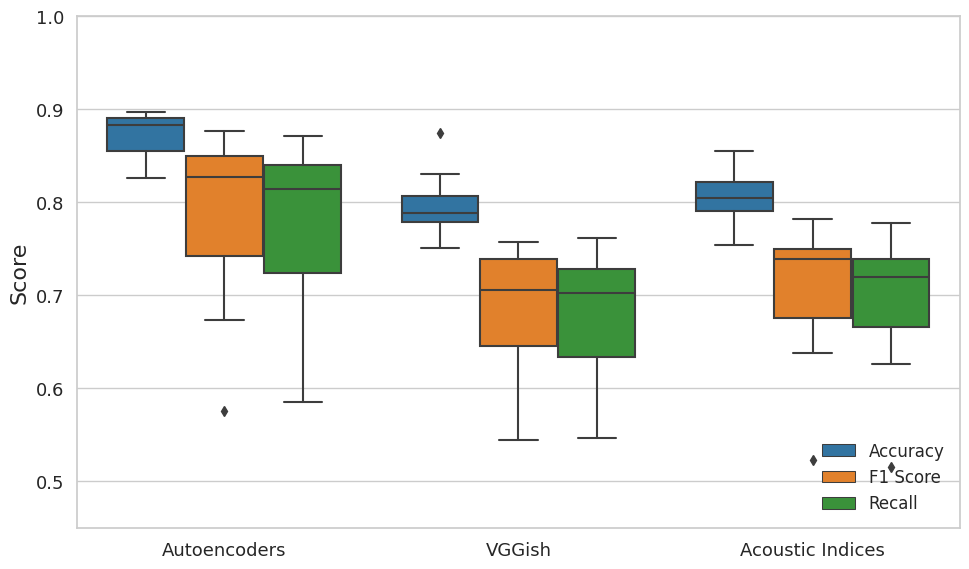

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Crear DataFrame
def build_dataframe(metric_values, metric_name, technique_name):
    return pd.DataFrame({
        'Score': metric_values,
        'Metric': metric_name,
        'Technique': technique_name
    })

# Construcción del DataFrame
df = pd.concat([
    build_dataframe(accuracies_ae_hours, 'Accuracy', 'Autoencoders'),
    build_dataframe(f1_scores_ae_hours, 'F1 Score', 'Autoencoders'),
    build_dataframe(recalls_ae_hours, 'Recall', 'Autoencoders'),
    build_dataframe(accuracies_vgg_hours, 'Accuracy', 'VGGish'),
    build_dataframe(f1_scores_vgg_hours, 'F1 Score', 'VGGish'),
    build_dataframe(recalls_vgg_hours, 'Recall', 'VGGish'),
    build_dataframe(accuracies_ai_hours, 'Accuracy', 'Acoustic Indices'),
    build_dataframe(f1_scores_ai_hours, 'F1 Score', 'Acoustic Indices'),
    build_dataframe(recalls_ai_hours, 'Recall', 'Acoustic Indices')
], ignore_index=True)

# Estética Seaborn
sns.set(style="whitegrid", font_scale=1.4)
palette = {'Accuracy': '#1f77b4', 'F1 Score': '#ff7f0e', 'Recall': '#2ca02c'}

# Crear el gráfico
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='Technique', y='Score', hue='Metric', palette=palette)

# Límites del eje y
ax.set_ylim(0.45, 1)

# Estética de ejes
ax.set_xlabel('')
ax.set_ylabel('Score', fontsize=16)
ax.tick_params(labelsize=13)
ax.legend(title='', fontsize=12, loc='lower right')

# Guardar y mostrar
plt.tight_layout()
plt.savefig("temporal_zamuro/zamuro_classification_results/figures/seaborn_combined_boxplot_hours.pdf",format="pdf", dpi=300)
plt.show()

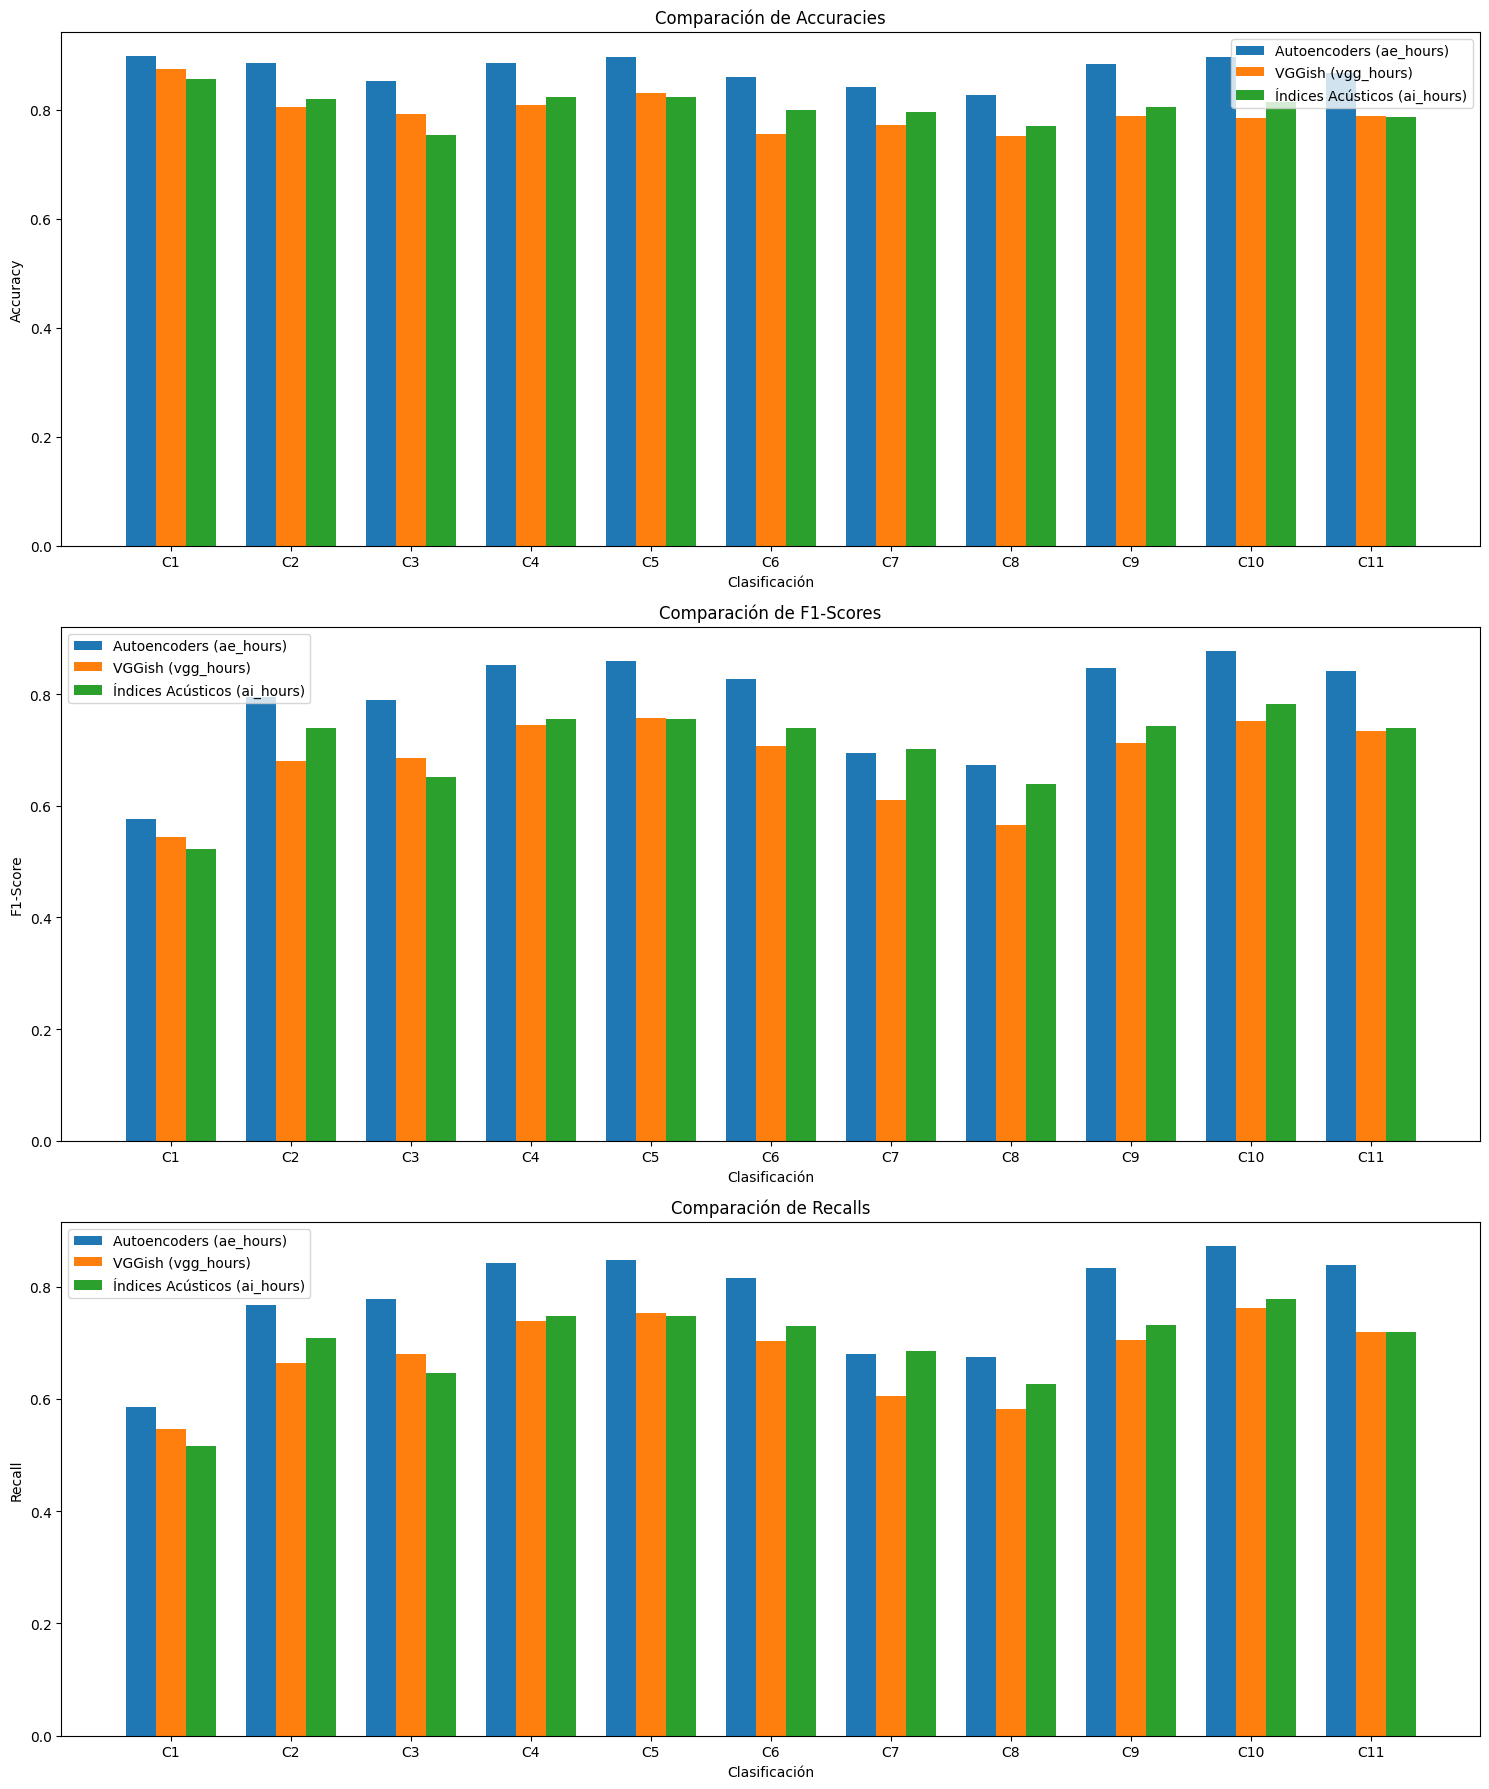

In [15]:
n = len(accuracies_ae_hours)

# Posiciones para las barras
ind = np.arange(n)  # la posición de las barras en el eje X
width = 0.25  # el ancho de las barras

fig, axs = plt.subplots(3, 1, figsize=(15, 18))

# Gráfica de accuracies
axs[0].bar(ind - width, accuracies_ae_hours, width, label='Autoencoders (ae_hours)')
axs[0].bar(ind, accuracies_vgg_hours, width, label='VGGish (vgg_hours)')
axs[0].bar(ind + width, accuracies_ai_hours, width, label='Índices Acústicos (ai_hours)')
axs[0].set_title('Comparación de Accuracies')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Clasificación')
axs[0].set_xticks(ind)
axs[0].set_xticklabels([f'C{i+1}' for i in ind])  # Etiquetas para cada clasificación
axs[0].legend(loc='best')

# Gráfica de F1-scores
axs[1].bar(ind - width, f1_scores_ae_hours, width, label='Autoencoders (ae_hours)')
axs[1].bar(ind, f1_scores_vgg_hours, width, label='VGGish (vgg_hours)')
axs[1].bar(ind + width, f1_scores_ai_hours, width, label='Índices Acústicos (ai_hours)')
axs[1].set_title('Comparación de F1-Scores')
axs[1].set_ylabel('F1-Score')
axs[1].set_xlabel('Clasificación')
axs[1].set_xticks(ind)
axs[1].set_xticklabels([f'C{i+1}' for i in ind])  # Etiquetas para cada clasificación
axs[1].legend(loc='best')

# Gráfica de Recalls
axs[2].bar(ind - width, recalls_ae_hours, width, label='Autoencoders (ae_hours)')
axs[2].bar(ind, recalls_vgg_hours, width, label='VGGish (vgg_hours)')
axs[2].bar(ind + width, recalls_ai_hours, width, label='Índices Acústicos (ai_hours)')
axs[2].set_title('Comparación de Recalls')
axs[2].set_ylabel('Recall')
axs[2].set_xlabel('Clasificación')
axs[2].set_xticks(ind)
axs[2].set_xticklabels([f'C{i+1}' for i in ind])  # Etiquetas para cada clasificación
axs[2].legend(loc='best')

# Ajustar la disposición de las gráficas
plt.tight_layout()
plt.show()

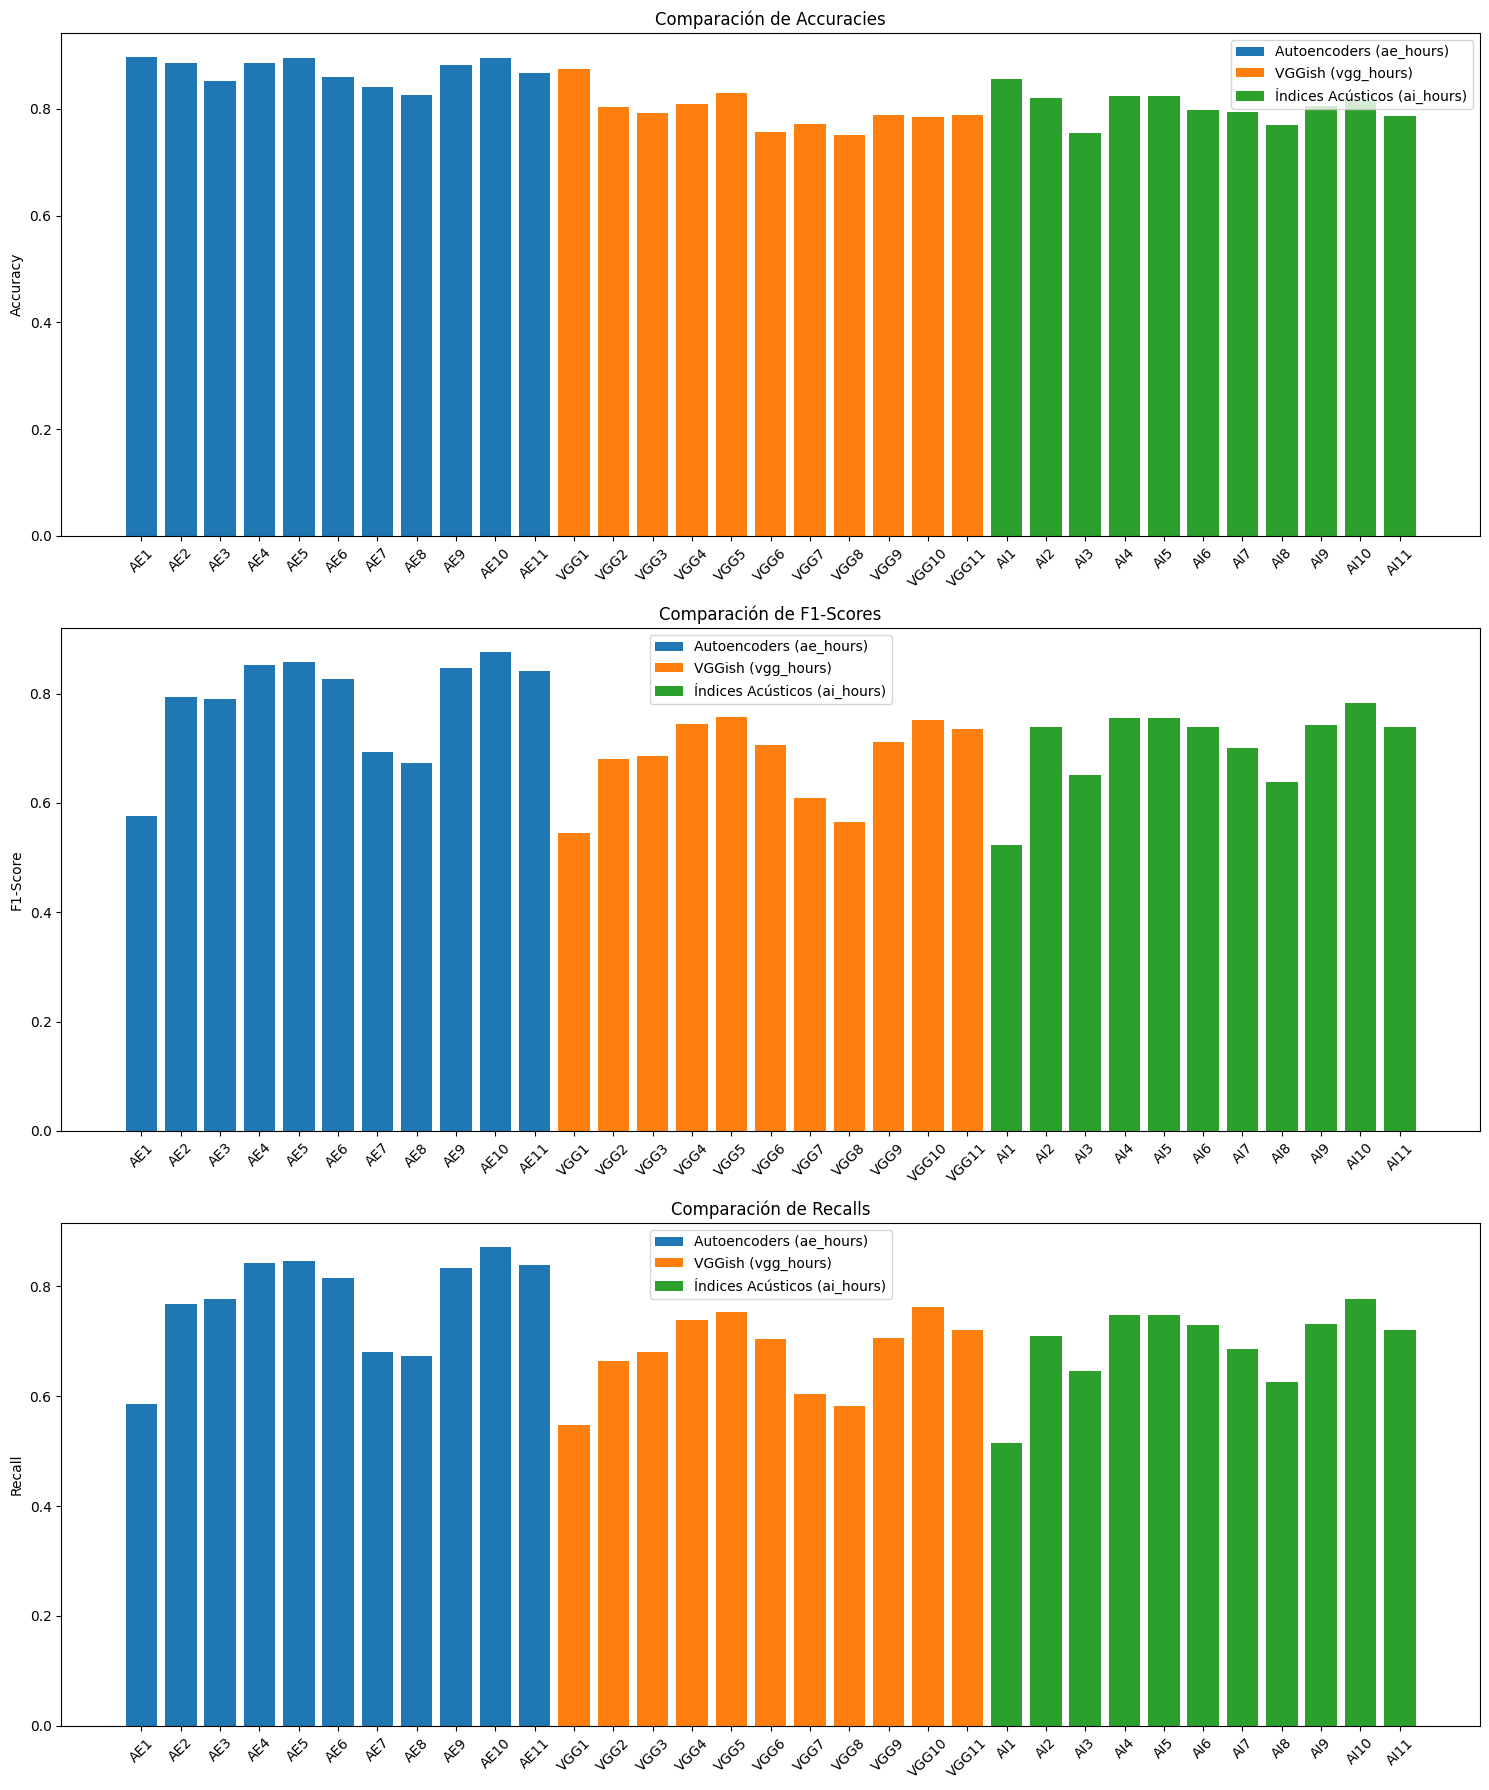

In [16]:
n = len(accuracies_ae_hours)

# Posiciones para las barras en el eje X
ind_ae = np.arange(n)  # Posiciones de las barras para el método AE
ind_vgg = np.arange(n, 2*n)  # Posiciones de las barras para el método VGGish
ind_ai = np.arange(2*n, 3*n)  # Posiciones de las barras para el método AI

# Ancho de las barras
width = 0.8  # el ancho de las barras, más amplio para que las barras estén más juntas dentro de cada grupo

fig, axs = plt.subplots(3, 1, figsize=(15, 18))

# Gráfica de accuracies
axs[0].bar(ind_ae, accuracies_ae_hours, width, label='Autoencoders (ae_hours)')
axs[0].bar(ind_vgg, accuracies_vgg_hours, width, label='VGGish (vgg_hours)')
axs[0].bar(ind_ai, accuracies_ai_hours, width, label='Índices Acústicos (ai_hours)')
axs[0].set_title('Comparación de Accuracies')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(np.concatenate([ind_ae, ind_vgg, ind_ai]))
axs[0].set_xticklabels(['AE'+str(i+1) for i in range(n)] + ['VGG'+str(i+1) for i in range(n)] + ['AI'+str(i+1) for i in range(n)], rotation=45)
axs[0].legend(loc='best')

# Gráfica de F1-scores
axs[1].bar(ind_ae, f1_scores_ae_hours, width, label='Autoencoders (ae_hours)')
axs[1].bar(ind_vgg, f1_scores_vgg_hours, width, label='VGGish (vgg_hours)')
axs[1].bar(ind_ai, f1_scores_ai_hours, width, label='Índices Acústicos (ai_hours)')
axs[1].set_title('Comparación de F1-Scores')
axs[1].set_ylabel('F1-Score')
axs[1].set_xticks(np.concatenate([ind_ae, ind_vgg, ind_ai]))
axs[1].set_xticklabels(['AE'+str(i+1) for i in range(n)] + ['VGG'+str(i+1) for i in range(n)] + ['AI'+str(i+1) for i in range(n)], rotation=45)
axs[1].legend(loc='best')

# Gráfica de Recalls
axs[2].bar(ind_ae, recalls_ae_hours, width, label='Autoencoders (ae_hours)')
axs[2].bar(ind_vgg, recalls_vgg_hours, width, label='VGGish (vgg_hours)')
axs[2].bar(ind_ai, recalls_ai_hours, width, label='Índices Acústicos (ai_hours)')
axs[2].set_title('Comparación de Recalls')
axs[2].set_ylabel('Recall')
axs[2].set_xticks(np.concatenate([ind_ae, ind_vgg, ind_ai]))
axs[2].set_xticklabels(['AE'+str(i+1) for i in range(n)] + ['VGG'+str(i+1) for i in range(n)] + ['AI'+str(i+1) for i in range(n)], rotation=45)
axs[2].legend(loc='best')

# Ajustar la disposición de las gráficas
plt.tight_layout()
plt.show()

In [17]:
from scipy.stats import friedmanchisquare, wilcoxon
friedman_acc = friedmanchisquare(accuracies_ae_hours, accuracies_vgg_hours, accuracies_ai_hours)
friedman_f1 = friedmanchisquare(f1_scores_ae_hours, f1_scores_vgg_hours, f1_scores_ai_hours)
friedman_rec = friedmanchisquare(recalls_ae_hours, recalls_vgg_hours, recalls_ai_hours)

print(f"Friedman Test for Accuracies: Statistic={friedman_acc.statistic}, p-value={friedman_acc.pvalue}")
print(f"Friedman Test for F1-Scores: Statistic={friedman_f1.statistic}, p-value={friedman_f1.pvalue}")
print(f"Friedman Test for Recalls: Statistic={friedman_rec.statistic}, p-value={friedman_rec.pvalue}")

Friedman Test for Accuracies: Statistic=16.909090909090907, p-value=0.00021293034712313702
Friedman Test for F1-Scores: Statistic=15.27272727272728, p-value=0.0004825801020447375
Friedman Test for Recalls: Statistic=14.363636363636374, p-value=0.0007602842497212054


In [18]:
from scipy.stats import friedmanchisquare, wilcoxon
import itertools

# Diccionarios con las métricas por técnica
accuracy_data = {
    'AE': accuracies_ae_hours,
    'VGG': accuracies_vgg_hours,
    'AI': accuracies_ai_hours
}
f1_data = {
    'AE': f1_scores_ae_hours,
    'VGG': f1_scores_vgg_hours,
    'AI': f1_scores_ai_hours
}
recall_data = {
    'AE': recalls_ae_hours,
    'VGG': recalls_vgg_hours,
    'AI': recalls_ai_hours
}

# === Friedman Tests ===
friedman_acc = friedmanchisquare(*accuracy_data.values())
friedman_f1 = friedmanchisquare(*f1_data.values())
friedman_rec = friedmanchisquare(*recall_data.values())

print("\n--- Friedman Test Results ---")
print(f"Accuracy   → Statistic = {friedman_acc.statistic:.3f}, p-value = {friedman_acc.pvalue:.4f}")
print(f"F1 Score   → Statistic = {friedman_f1.statistic:.3f}, p-value = {friedman_f1.pvalue:.4f}")
print(f"Recall     → Statistic = {friedman_rec.statistic:.3f}, p-value = {friedman_rec.pvalue:.4f}")




--- Friedman Test Results ---
Accuracy   → Statistic = 16.909, p-value = 0.0002
F1 Score   → Statistic = 15.273, p-value = 0.0005
Recall     → Statistic = 14.364, p-value = 0.0008


In [18]:
wilcoxon_acc_ae_vgg = wilcoxon(accuracies_ae_hours, accuracies_vgg_hours)
wilcoxon_acc_ae_ai = wilcoxon(accuracies_ae_hours, accuracies_ai_hours)

wilcoxon_f1_ae_vgg = wilcoxon(f1_scores_ae_hours, f1_scores_vgg_hours)
wilcoxon_f1_ae_ai = wilcoxon(f1_scores_ae_hours, f1_scores_ai_hours)

wilcoxon_rec_ae_vgg = wilcoxon(recalls_ae_hours, recalls_vgg_hours)
wilcoxon_rec_ae_ai = wilcoxon(recalls_ae_hours, recalls_ai_hours)

print(f"Wilcoxon Test Accuracies AE vs VGG: Statistic={wilcoxon_acc_ae_vgg.statistic}, p-value={wilcoxon_acc_ae_vgg.pvalue}")
print(f"Wilcoxon Test Accuracies AE vs AI: Statistic={wilcoxon_acc_ae_ai.statistic}, p-value={wilcoxon_acc_ae_ai.pvalue}")

print(f"Wilcoxon Test F1-Scores AE vs VGG: Statistic={wilcoxon_f1_ae_vgg.statistic}, p-value={wilcoxon_f1_ae_vgg.pvalue}")
print(f"Wilcoxon Test F1-Scores AE vs AI: Statistic={wilcoxon_f1_ae_ai.statistic}, p-value={wilcoxon_f1_ae_ai.pvalue}")

print(f"Wilcoxon Test Recalls AE vs VGG: Statistic={wilcoxon_rec_ae_vgg.statistic}, p-value={wilcoxon_rec_ae_vgg.pvalue}")
print(f"Wilcoxon Test Recalls AE vs AI: Statistic={wilcoxon_rec_ae_ai.statistic}, p-value={wilcoxon_rec_ae_ai.pvalue}")

Wilcoxon Test Accuracies AE vs VGG: Statistic=0.0, p-value=0.0009765625
Wilcoxon Test Accuracies AE vs AI: Statistic=0.0, p-value=0.0009765625
Wilcoxon Test F1-Scores AE vs VGG: Statistic=0.0, p-value=0.0009765625
Wilcoxon Test F1-Scores AE vs AI: Statistic=1.0, p-value=0.001953125
Wilcoxon Test Recalls AE vs VGG: Statistic=0.0, p-value=0.0009765625
Wilcoxon Test Recalls AE vs AI: Statistic=1.0, p-value=0.001953125


In [19]:
from scipy.stats import wilcoxon
import itertools

# === Wilcoxon Pairwise Function ===
def run_pairwise_wilcoxon(data_dict, metric_name):
    print(f"\n--- Wilcoxon Pairwise Tests for {metric_name} ---")
    for (name1, values1), (name2, values2) in itertools.combinations(data_dict.items(), 2):
        try:
            result = wilcoxon(values1, values2)
            print(f"{name1} vs {name2} → Statistic = {result.statistic:.3f}, p-value = {result.pvalue:.4f}")
        except ValueError as e:
            print(f"{name1} vs {name2} → Wilcoxon test failed ({e})")

# Ejecutar para cada métrica
run_pairwise_wilcoxon(accuracy_data, "Accuracy")
run_pairwise_wilcoxon(f1_data, "F1 Score")
run_pairwise_wilcoxon(recall_data, "Recall")



--- Wilcoxon Pairwise Tests for Accuracy ---
AE vs VGG → Statistic = 0.000, p-value = 0.0010
AE vs AI → Statistic = 0.000, p-value = 0.0010
VGG vs AI → Statistic = 20.000, p-value = 0.2783

--- Wilcoxon Pairwise Tests for F1 Score ---
AE vs VGG → Statistic = 0.000, p-value = 0.0010
AE vs AI → Statistic = 1.000, p-value = 0.0020
VGG vs AI → Statistic = 13.000, p-value = 0.0830

--- Wilcoxon Pairwise Tests for Recall ---
AE vs VGG → Statistic = 0.000, p-value = 0.0010
AE vs AI → Statistic = 1.000, p-value = 0.0020
VGG vs AI → Statistic = 18.000, p-value = 0.2061
